# Load data

## Read data

In [143]:
library(tidyverse)
library(Seurat)
library(sf)
library(anndata)
library(biomaRt)
library(Matrix)
library(BiocParallel)

set.seed(42)

In [144]:
## read sc counts from MS1 (there are three)
sc_mtx <- Read10X_h5('../original_data/single_cell/Kidney_MS_1.h5')

## read srt counts
srt_mtx <- Matrix::readMM('../original_data/male_cartana/male_ctx.mtx')
rownames(srt_mtx) <- read.csv('../original_data/male_cartana/male_genes.csv', 
                              header = F) %>% 
  pull(V1)
colnames(srt_mtx) <- read.csv('../original_data/male_cartana/male_cells.csv', 
                              header = F) %>% 
  pull(V1)
## read srt metadata
srt_meta <- read.csv('../original_data/male_cartana/male_meta.csv', row.names = 1)

In [145]:
sc_meta <- read.csv('../sim_data/prox_assign/sc_meta.csv', row.names = 1)

# Create cell boundaries

I used circles, it's a limitation of the current method.

In [146]:
meta <- sc_meta %>%
    mutate(radius = sqrt(area / pi))
head(meta)

,cell,x,y,elongation,area,srt_cell,radius
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,AAACCCAAGGTAAGGA-1,6589.351,18596.79,2.833,1390.0,Sham_21413,21.03451
2,AAACCCAAGTCCCAAT-1,6706.731,13677.54,4.263,1565.0,Sham_11856,22.31939
3,AAACCCACACCCTTGT-1,6332.787,13920.69,1.300,1403.0,Sham_11605,21.13265
4,AAACCCACACCGGAAA-1,5329.179,14816.21,33.140,517.4,Sham_11383,12.83330
5,AAACCCACAGACGGAT-1,12377.961,19690.29,1.846,6045.0,Sham_38551,43.86551
6,AAACCCACAGTCGGTC-1,13846.138,18517.05,5.112,378.9,Sham_39301,10.98215


In [147]:
## create circles representing the cell boundaries
circles <- lapply(1:dim(meta)[1], 
                  FUN = function(i) {
                    cell <- meta[i, ]
                    st_buffer(st_point(c(cell$x, cell$y)), 
                              dist = sqrt(cell$area / pi))
                  })
names(circles) <- meta$cell

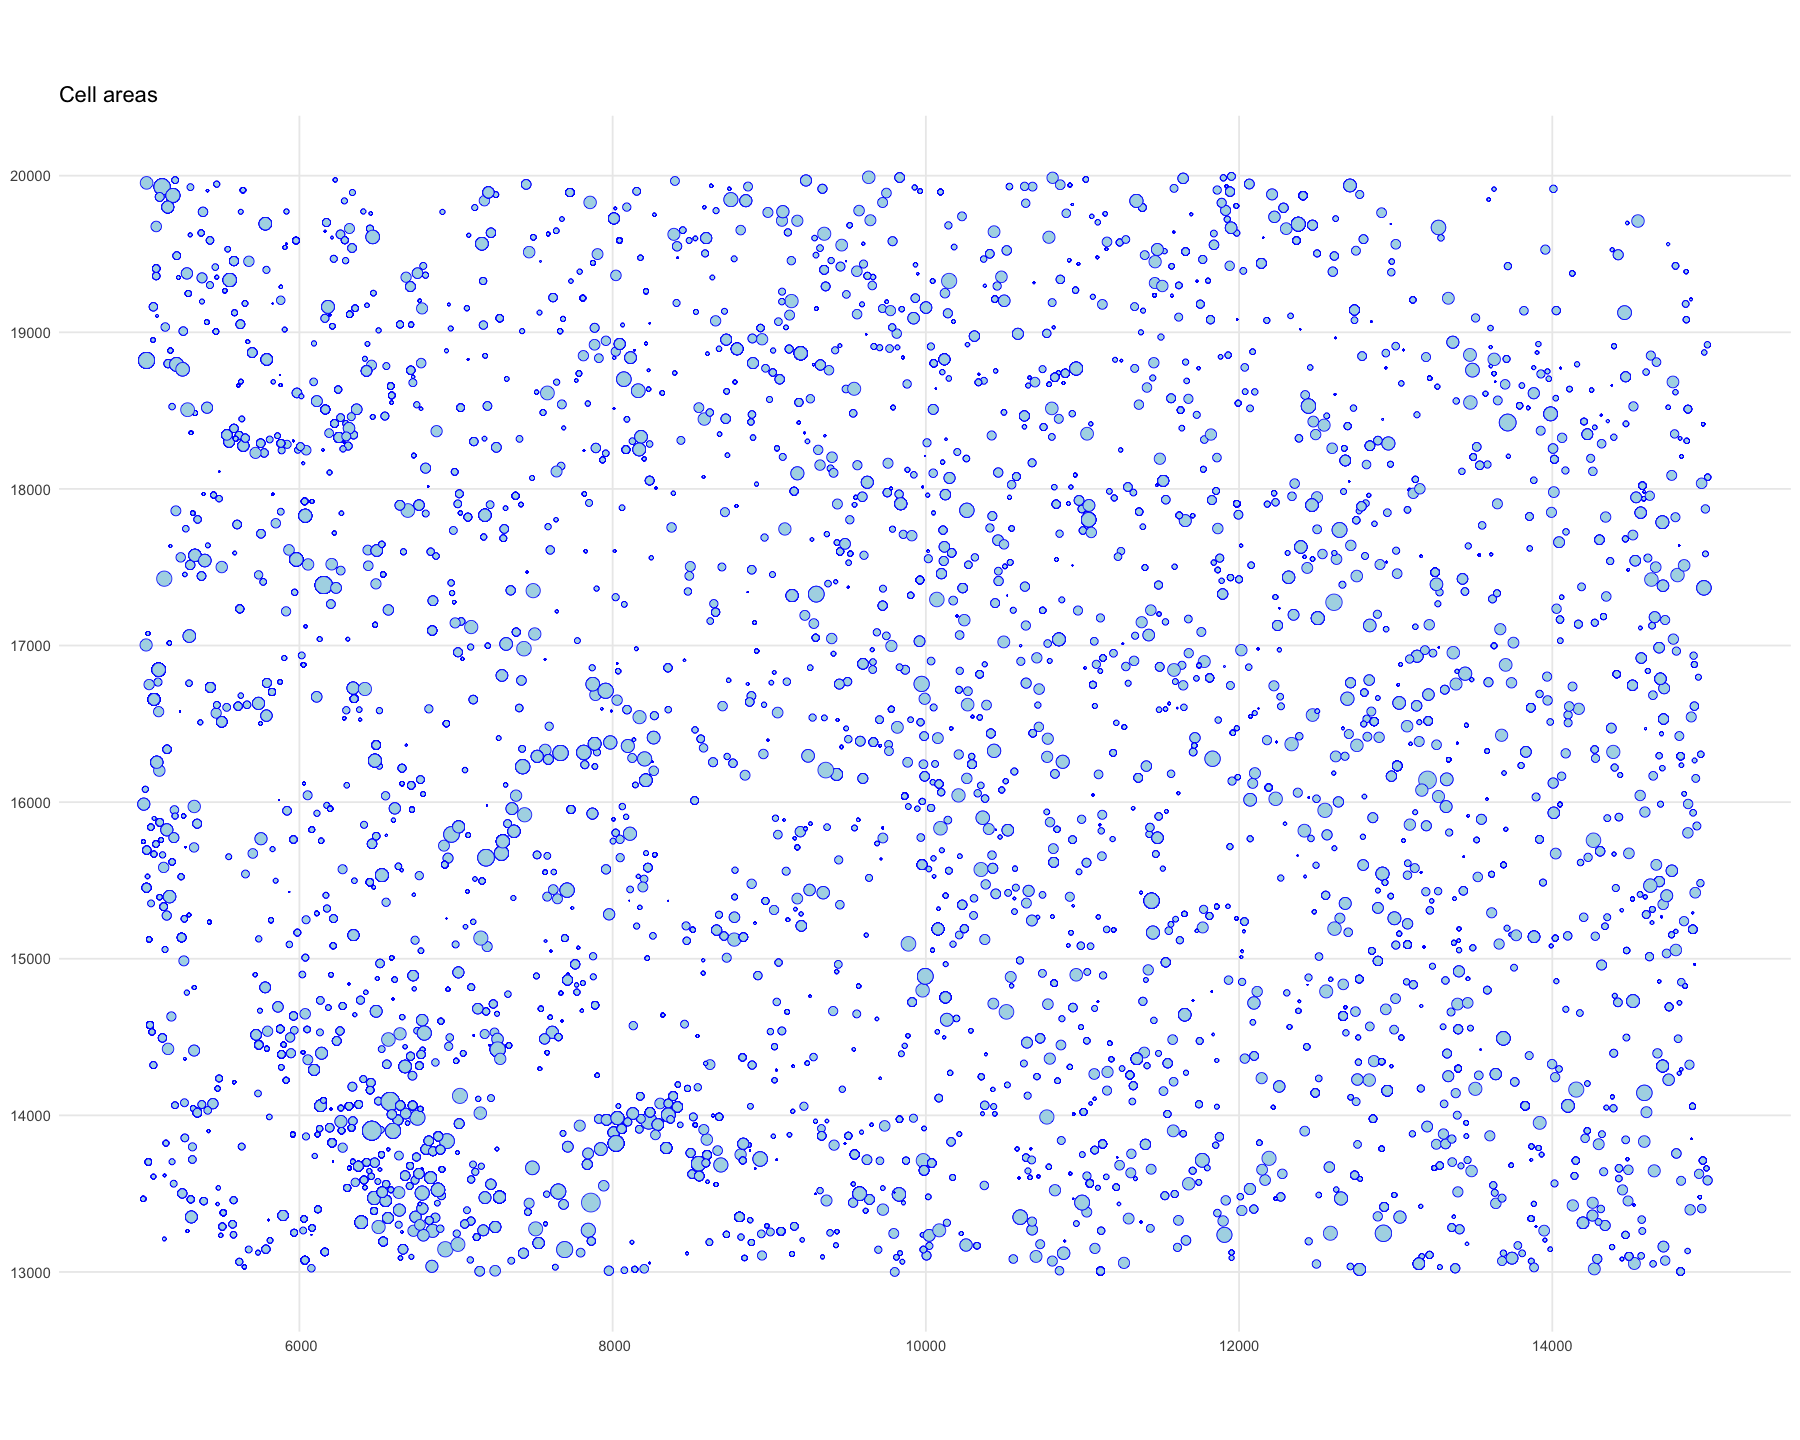

In [148]:
## plot cell areas
options(repr.plot.width = 15, repr.plot.height = 12)
circles_sf <- st_sfc(circles) %>% st_sf()
ggplot(data = circles_sf) +
  geom_sf(fill = "lightblue", color = "blue") +
  theme_minimal() +
  labs(title = "Cell areas")
## some cells overlap

# Simulate diffusion

## Filter matrix

In [149]:
## filter matrix to match metadata from assigned positions
mtx <- sc_mtx[, meta$cell]
dim(mtx)

[1] 31053 11273

There are a lot of genes in this dataset, some can be removed, like mt genes. Since the more genes we have the longer it takes to simulate the data, I decided to remove some of the genes.

In [ ]:
# ## get protein coding genes
# ## connect to Ensembl Biomart
# mart <- useEnsembl("ensembl", dataset = "mmusculus_gene_ensembl", mirror = "useast")

In [ ]:
# ## get a list of protein-coding genes
# protein_coding_genes <- getBM(
#   attributes = c("external_gene_name", "gene_biotype"),
#   filters = "biotype",
#   values = "protein_coding",
#   mart = mart
# )$external_gene_name

# length(protein_coding_genes)

[1] 21618

In [150]:
## save to avoid connecting to the server
# saveRDS(protein_coding_genes, '../sim_data/protein_coding_genes.RDS')
protein_coding_genes <- readRDS('../sim_data/protein_coding_genes.RDS')

In [155]:
## remove mt genes
selected_genes <- protein_coding_genes[!grepl("^mt-", protein_coding_genes)]
length(selected_genes)

[1] 21605

In [156]:
## remove ribo genes
selected_genes <- selected_genes[!grepl("^Rpl", selected_genes)]
selected_genes <- selected_genes[!grepl("^Rps", selected_genes)]
length(selected_genes)

[1] 21500

In [158]:
## filter matrix
common_genes <- intersect(rownames(mtx), selected_genes)
mtx <- mtx[common_genes, ]
dim(mtx)

[1] 18873 11273

In [160]:
## save matrix
saveRDS(mtx, "../sim_data/prox_assign/mtx_all_genes.RDS")

In [161]:
## get HVGs to make the code faster
seurat_obj <- CreateSeuratObject(counts = mtx)
seurat_obj <- NormalizeData(seurat_obj)

Normalizing layer: counts



Finding variable features for layer counts



 [1] "Ccl4"   "Hba-a1" "H2-Aa"  "Hba-a2" "H2-Eb1" "Cd74"   "Hbb-bs" "Acta2" 
 [9] "Ccl3"   "Il1b"  


Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


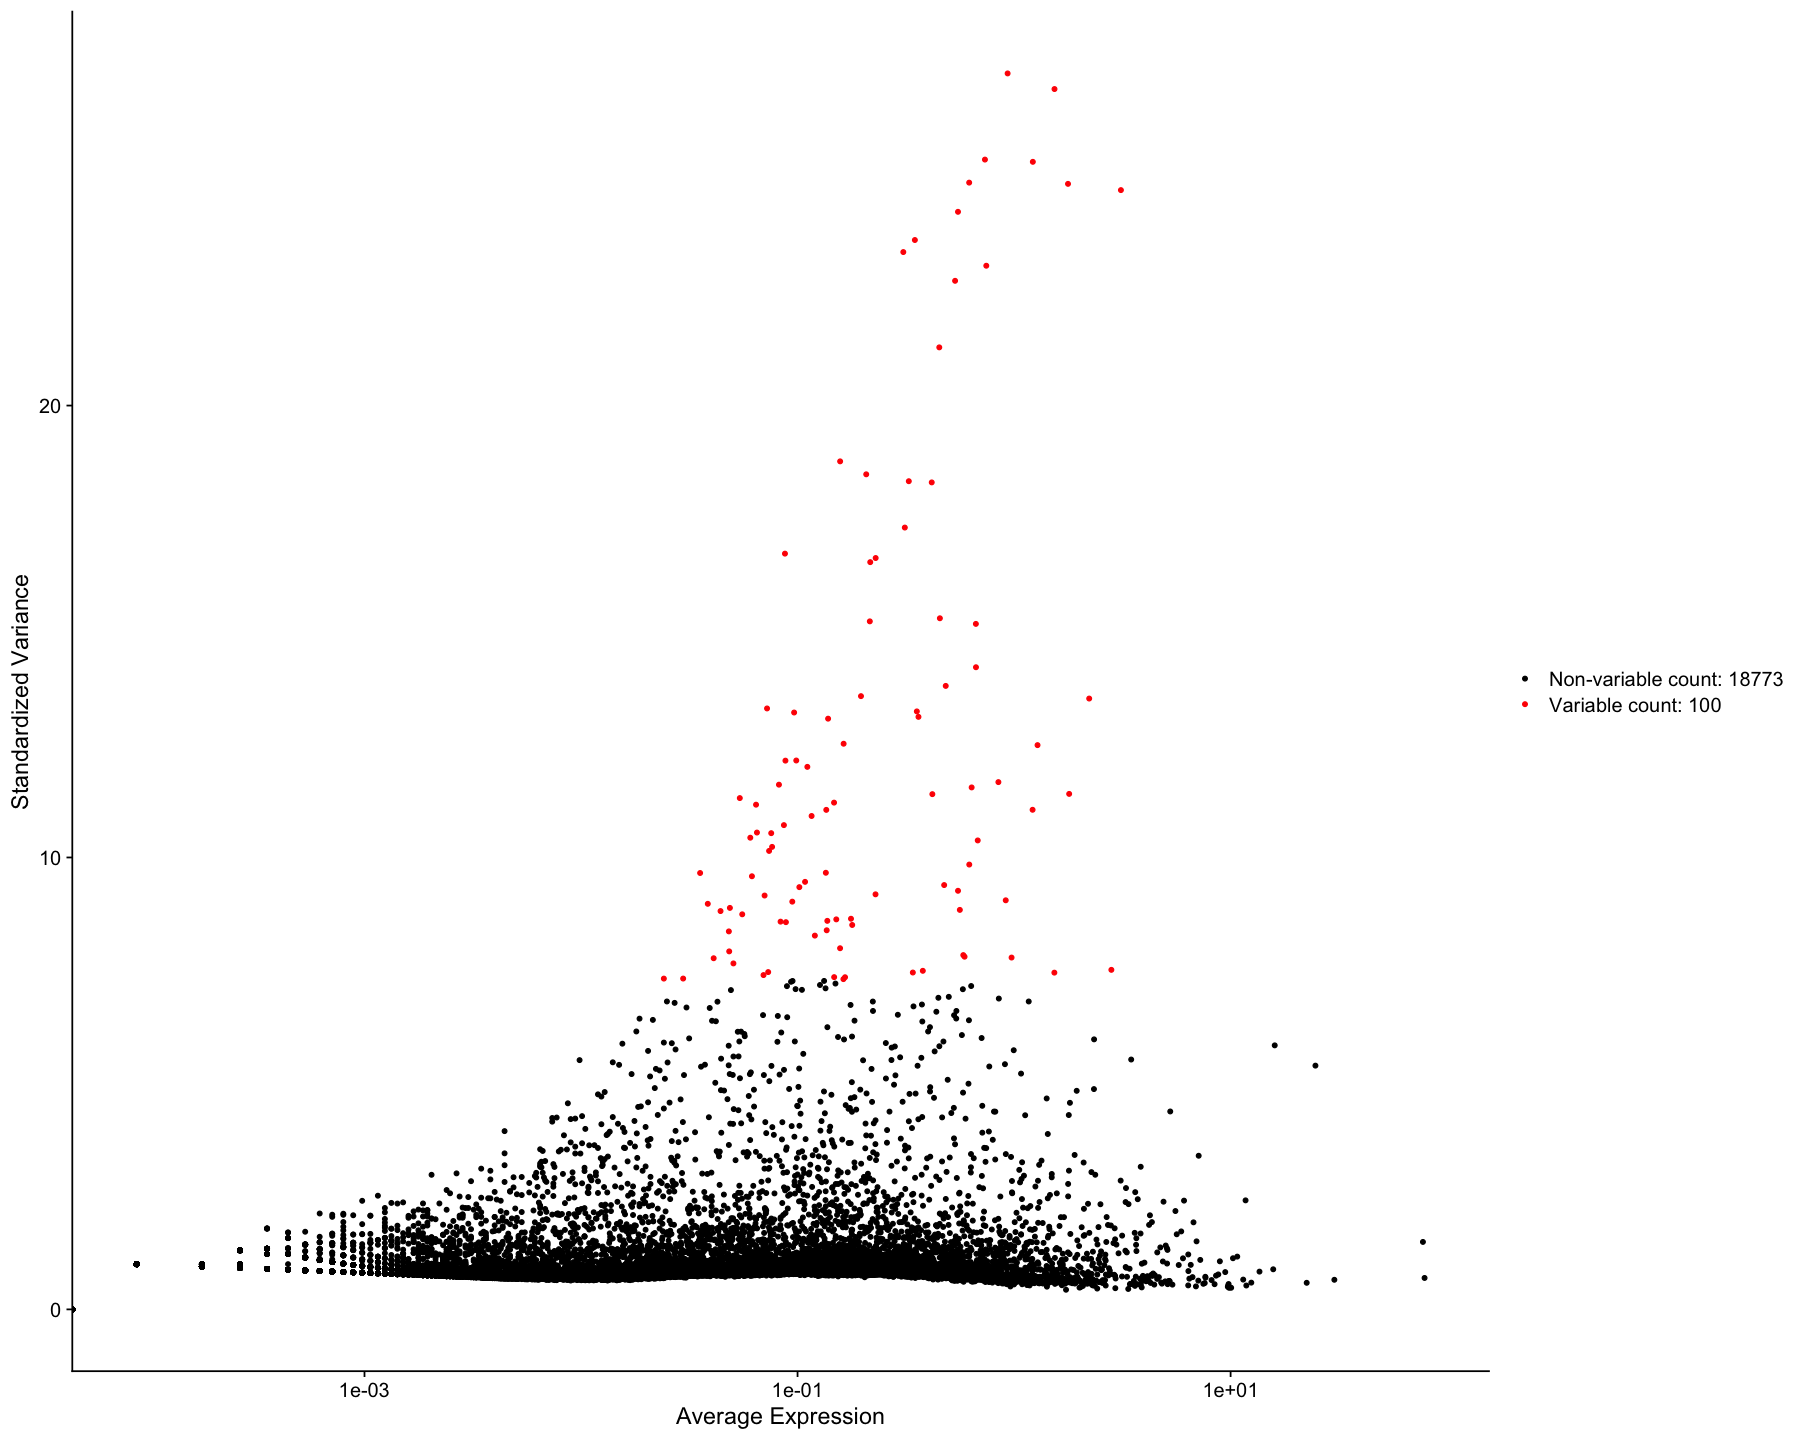

In [168]:
## top 100
seurat_obj100 <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 100)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(seurat_obj100), 10)
print(top10)

# plot variable features with and without labels
VariableFeaturePlot(seurat_obj100)

In [172]:
## save matrix
hvgs <- VariableFeatures(seurat_obj100)
hvg_mtx <- mtx[hvgs, ]
dim(hvg_mtx)
saveRDS(hvg_mtx, "../sim_data/prox_assign/mtx_100_genes.RDS")

[1]   100 11273

Finding variable features for layer counts

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


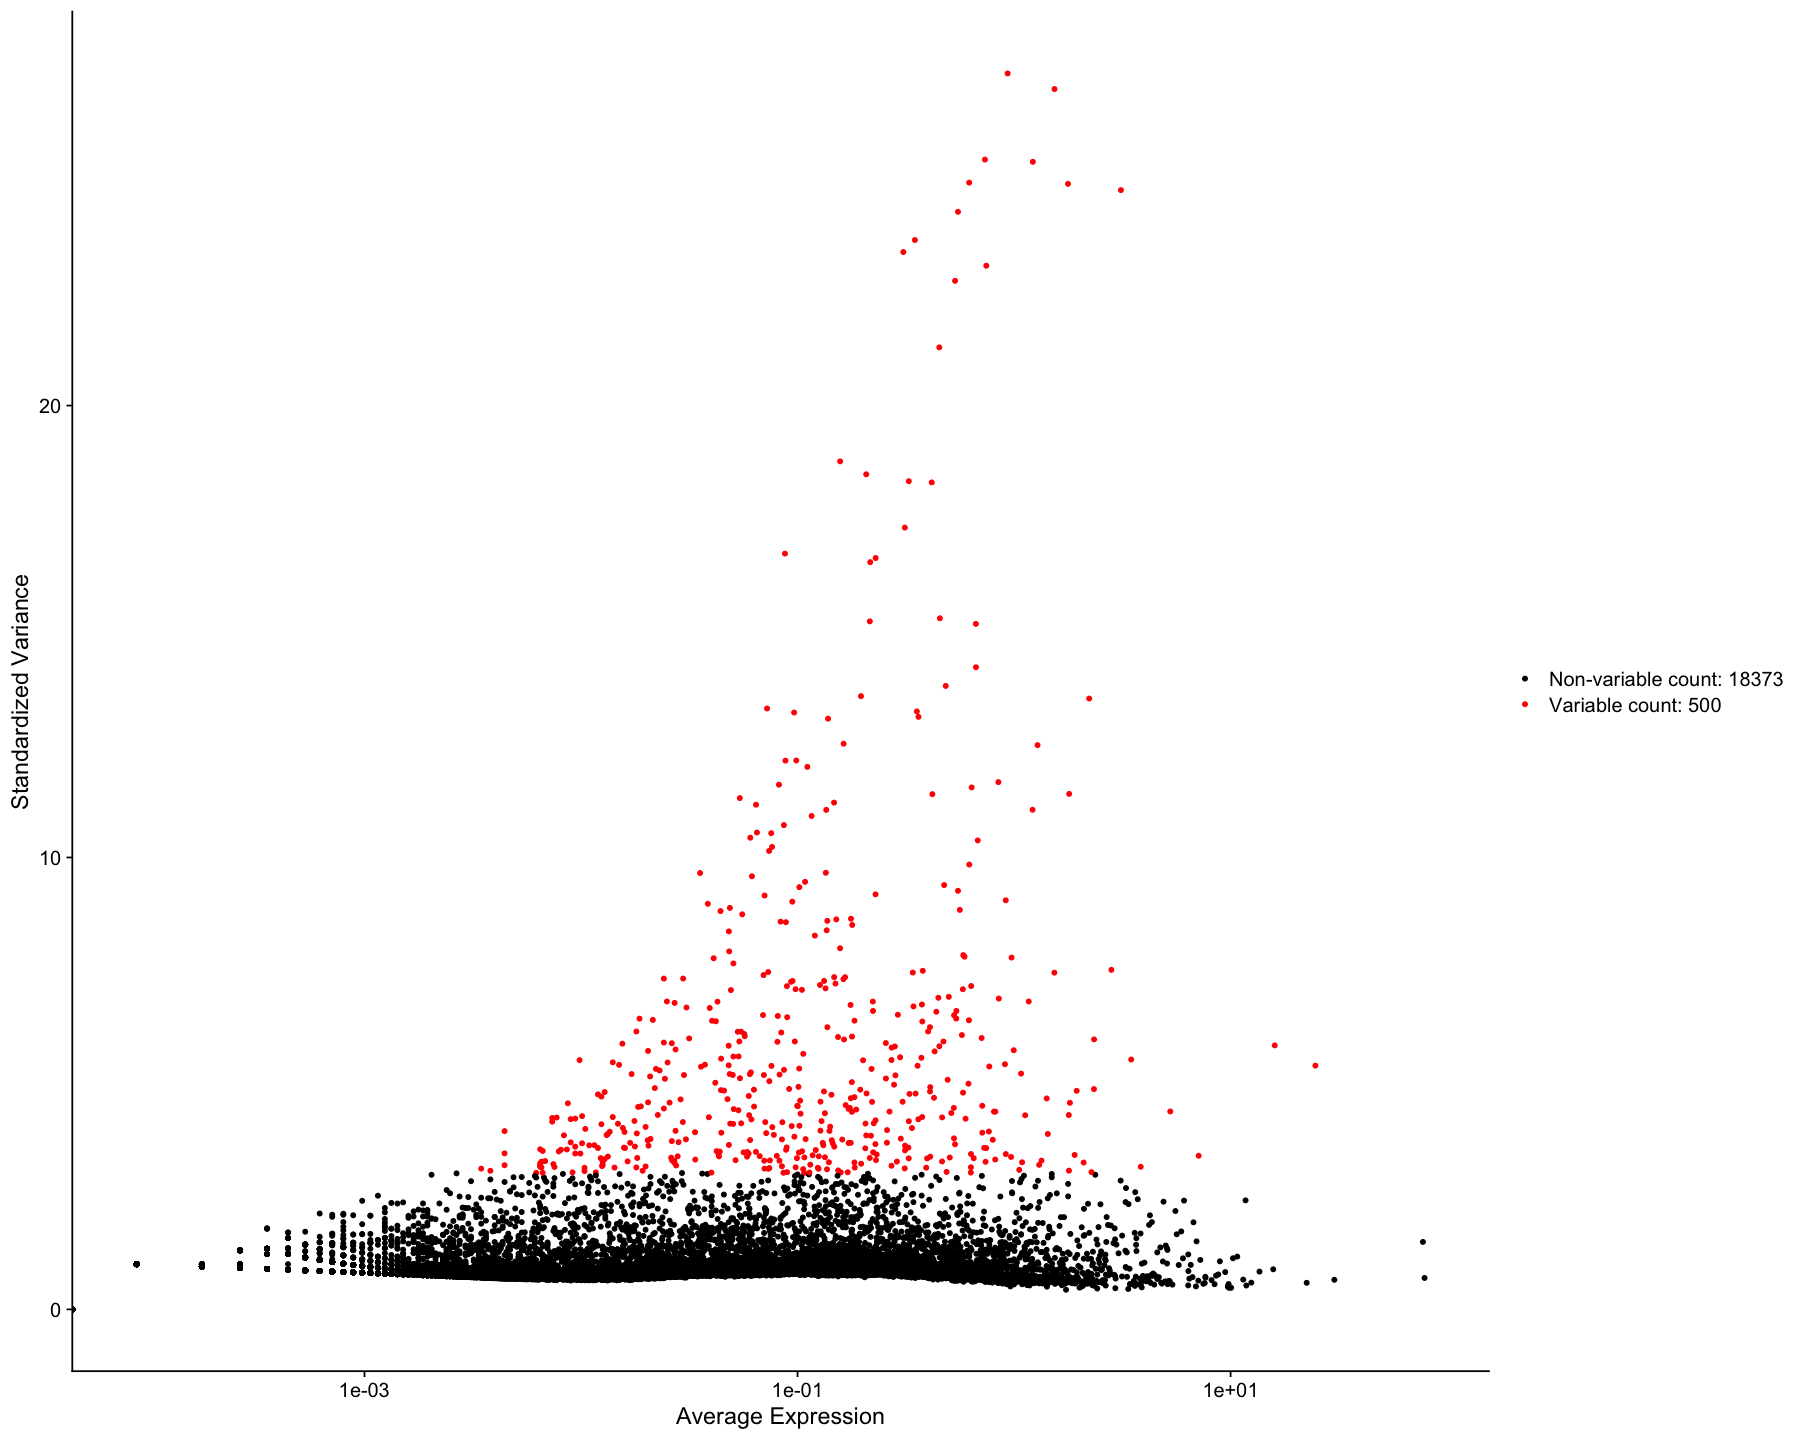

In [173]:
## top 500
seurat_obj500 <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 500)

# plot variable features with and without labels
VariableFeaturePlot(seurat_obj500)

In [174]:
## save matrix
hvgs <- VariableFeatures(seurat_obj500)
hvg_mtx <- mtx[hvgs, ]
dim(hvg_mtx)
saveRDS(hvg_mtx, "../sim_data/prox_assign/mtx_500_genes.RDS")

[1]   500 11273

Finding variable features for layer counts

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


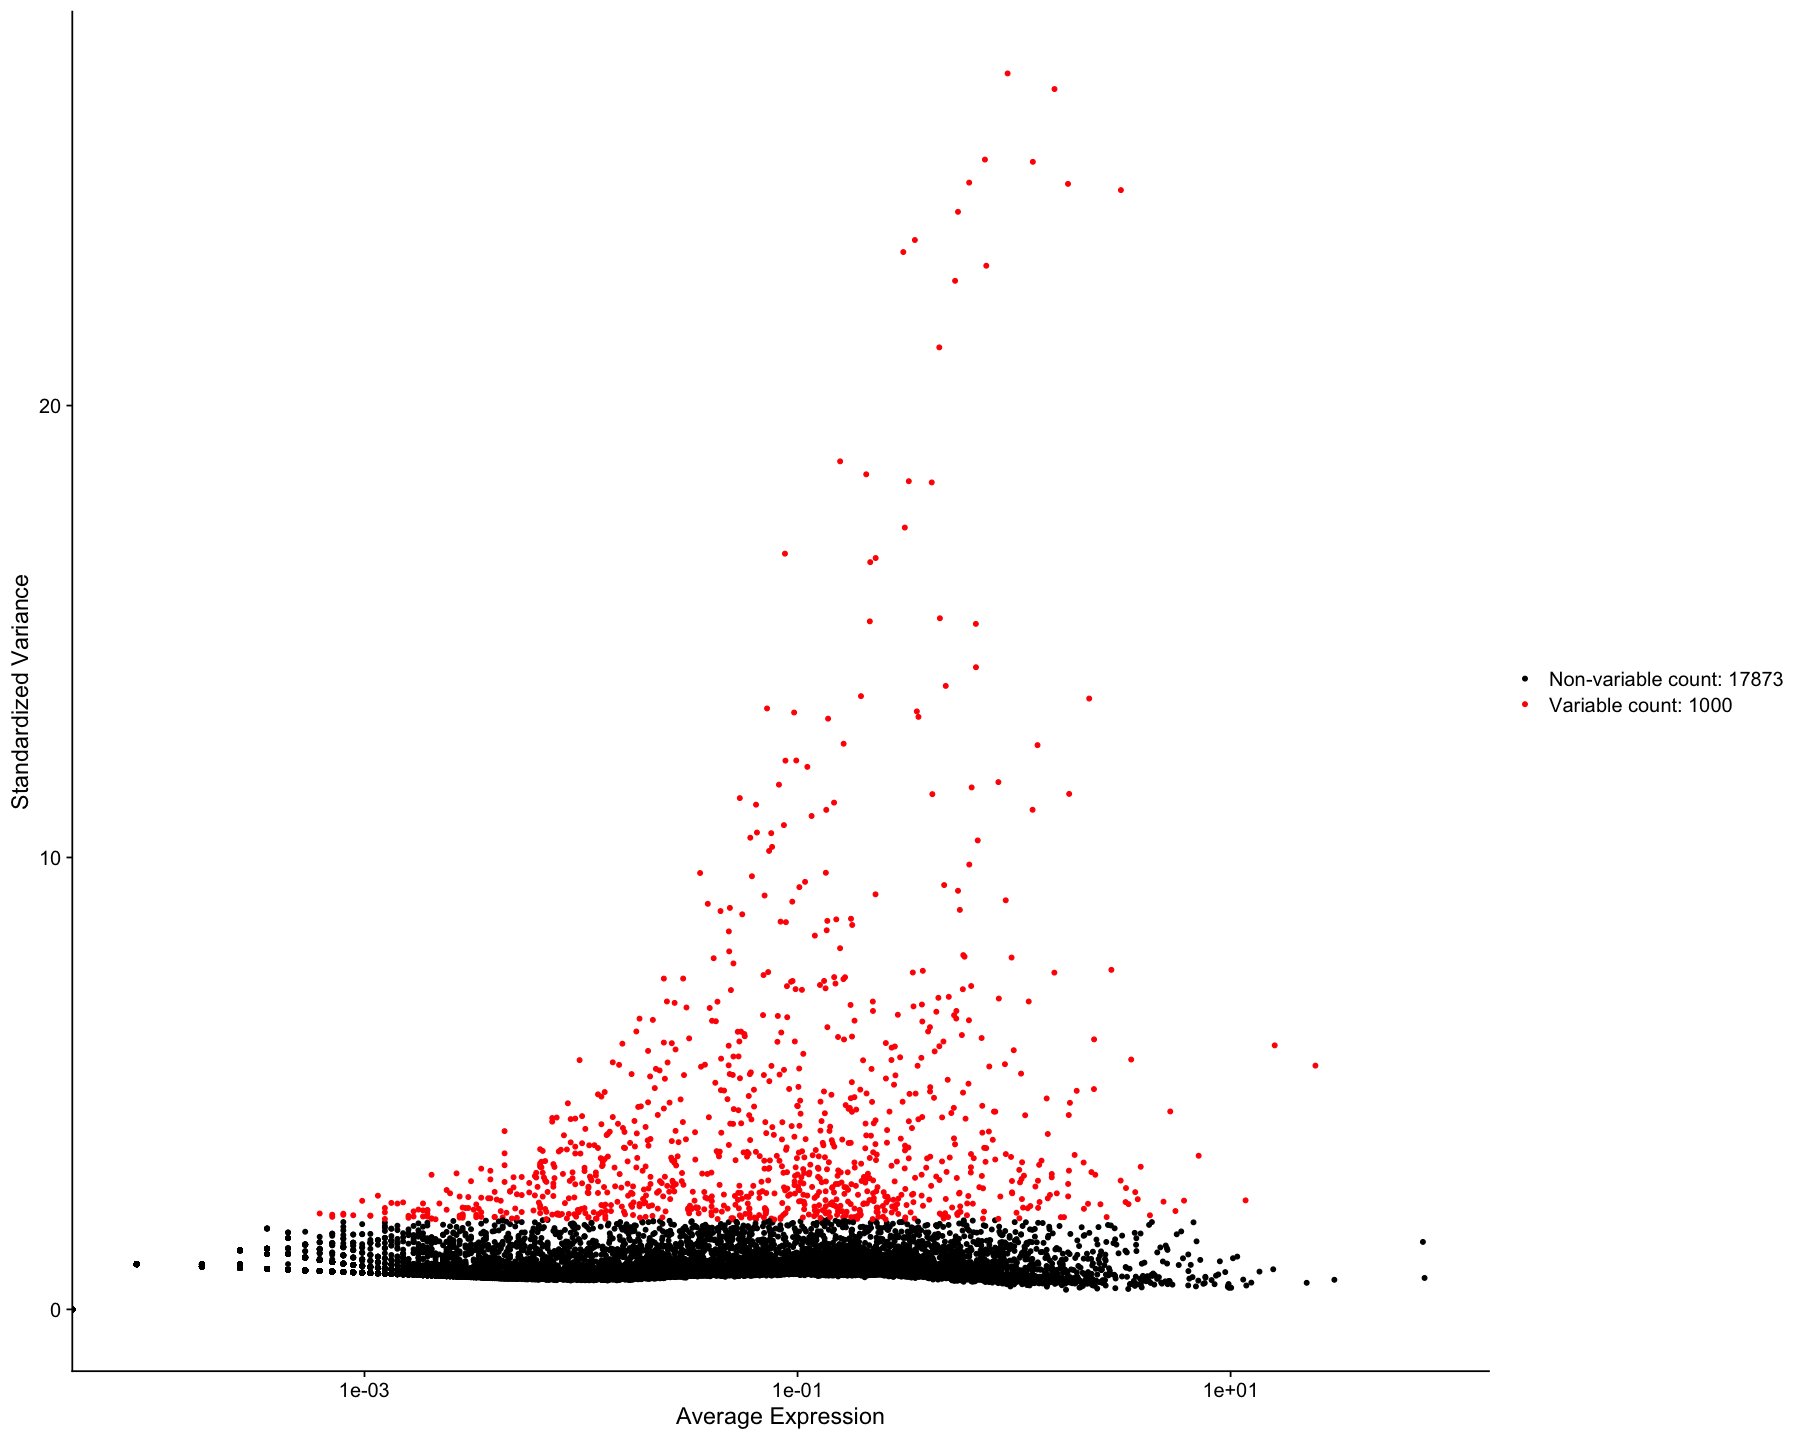

In [175]:
## top 1000
seurat_obj1000 <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 1000)

# plot variable features with and without labels
VariableFeaturePlot(seurat_obj1000)

In [176]:
## save matrix
hvgs <- VariableFeatures(seurat_obj1000)
hvg_mtx <- mtx[hvgs, ]
dim(hvg_mtx)
saveRDS(hvg_mtx, "../sim_data/prox_assign/mtx_1000_genes.RDS")

[1]  1000 11273

Finding variable features for layer counts

Warning message in scale_x_log10():
"log-10 transformation introduced infinite values."


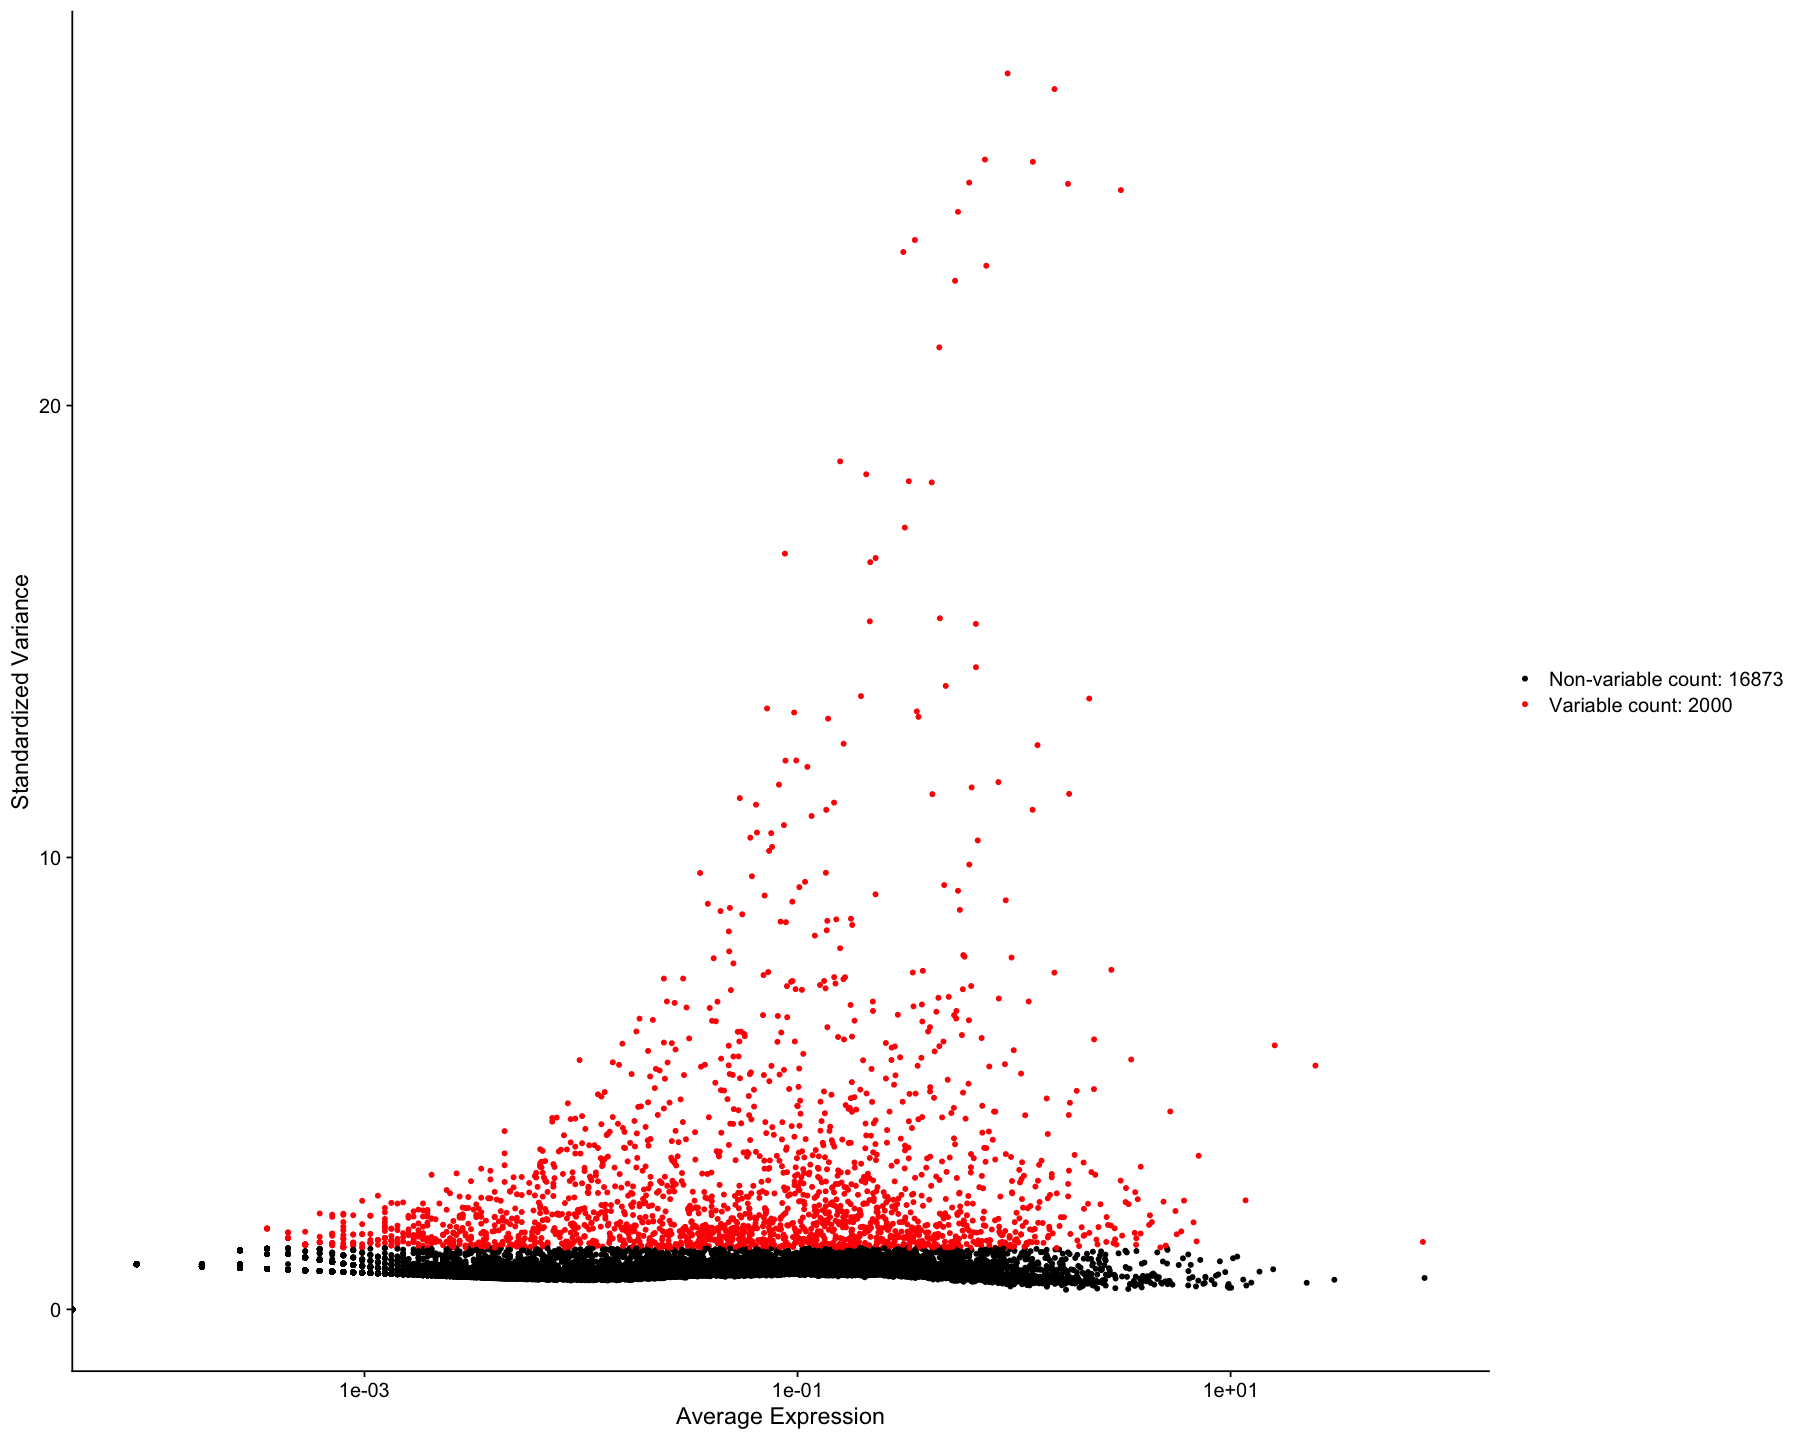

In [177]:
## top 2000
seurat_obj2000 <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

# plot variable features with and without labels
VariableFeaturePlot(seurat_obj2000)

## Simulate datasets

In [178]:
## simulate transcript positions
simulate_mtx <- function(mtx, meta, pct_out, min_dist, max_dist) {
  rownames(meta) <- meta$cell

  ## empty matrix to get the transcripts later
  sim_mtx <- Matrix::sparseMatrix(dim(mtx)[1],
    dim(mtx)[2],
    x = 0
  )
  rownames(sim_mtx) <- rownames(mtx)
  colnames(sim_mtx) <- colnames(mtx)

  ## create df with transcript coordinates represented by the cell center
  transcripts <- data.frame()
  ## for every cell
  for (i in 1:dim(meta)[1]) {
    cell <- meta[i, ]
    cell_id <- cell$cell
    ## get expressed transcripts
    ts <- mtx[which(mtx[, cell_id] > 0), cell_id]
    ## calculate transcripts outside and inside the cell
    ts_out <- round(ts * pct_out)
    ts_in <- ts - ts_out

    ## populate exp matrix with the transcripts inside the cell
    for (ts_name in names(ts)) {
      sim_mtx[ts_name, cell_id] <- ts_in[ts_name]
    }

    ## calculate positions of the transcripts outside
    r <- cell$radius
    for (ts_name in names(ts)) {
      ## generate random position for transcript given cell centroid
      ## calculate angle
      theta <- runif(1, 0, 2 * pi)
      ## calculate distance
      d <- runif(1, r * min_dist, r * max_dist)
      x <- cell$x + d * cos(theta)
      y <- cell$y + d * sin(theta)
      ## add to dataframe
      transcripts <- rbind(transcripts, c(ts_name, x, y, cell_id))
    }
  }
  colnames(transcripts) <- c("gene", "x", "y", "orig_cell")
  transcripts <- transcripts %>%
    mutate(x = as.numeric(x), y = as.numeric(y))

  ## for each cell, calculate intersection
  for (i in 1:dim(meta)[1]) {
    cell <- meta[i, ]
    ## intersect genes with cell
    ## filter genes near to speed the process
    near_transcripts <- transcripts %>% 
      mutate(distance = sqrt((x - cell$x)^2 + (y - cell$y)^2)) %>% 
      filter(distance <= cell$radius)
    ## if no genes are near, just skip
    if (dim(near_transcripts)[1] > 0) {
      genes_in <- near_transcripts$gene
      ## add the number of copies to the sim matrix
      if (length(genes_in) > 0) {
        count_genes_in <- table(genes_in)
        for (ts_name in names(count_genes_in)) {
          sim_mtx[ts_name, cell_id] <- sim_mtx[ts_name, cell_id] +
            count_genes_in[ts_name]
        }
      }
    }
  }

  return(sim_mtx)
}

In [179]:
tmp_mtx <- mtx[1:100, 1:100]
tmp_meta <- meta %>% filter(cell %in% colnames(tmp_mtx))
tmp <- simulate_mtx(tmp_mtx, tmp_meta, .5, 1.001, 5)

In [181]:
## use mtx with 500 svgs
hvgs <- VariableFeatures(seurat_obj500)
hvg_mtx <- mtx[hvgs, ]
dim(hvg_mtx)

[1]   500 11273

In [182]:
sim_dat_5pct <- simulate_mtx(hvg_mtx, meta, .05, 1, 2)

In [184]:
## save
saveRDS(sim_dat_5pct, '../sim_data/prox_assign/ld_mtx_5pct.RDS')

Check summary stats for this dataset to see if it is similar to the parallelized one.

In [187]:
paste(mean(hvg_mtx), median(hvg_mtx), 
  max(hvg_mtx), min(hvg_mtx), sum(hvg_mtx > 0), sep = '    ')

[1] "0.390971879712588    0    2976    0    344070"

In [185]:
paste(mean(sim_dat_5pct), median(sim_dat_5pct),
  max(sim_dat_5pct), min(sim_dat_5pct),
  sum(sim_dat_5pct > 0), sep = '    ')

[1] "0.405462077530382    0    5457    0    344526"

In [190]:
counts_per_cell <- colSums(hvg_mtx)
paste(mean(counts_per_cell), median(counts_per_cell), 
  max(counts_per_cell), min(counts_per_cell),
  sum(counts_per_cell > 0), sep = '    ')

[1] "195.485939856294    43    6584    1    11273"

In [189]:
counts_per_cell <- colSums(sim_dat_5pct)
paste(mean(counts_per_cell), median(counts_per_cell), 
  max(counts_per_cell), min(counts_per_cell),
  sum(counts_per_cell > 0), sep = '    ')

[1] "202.731038765189    43    161842    0    11268"

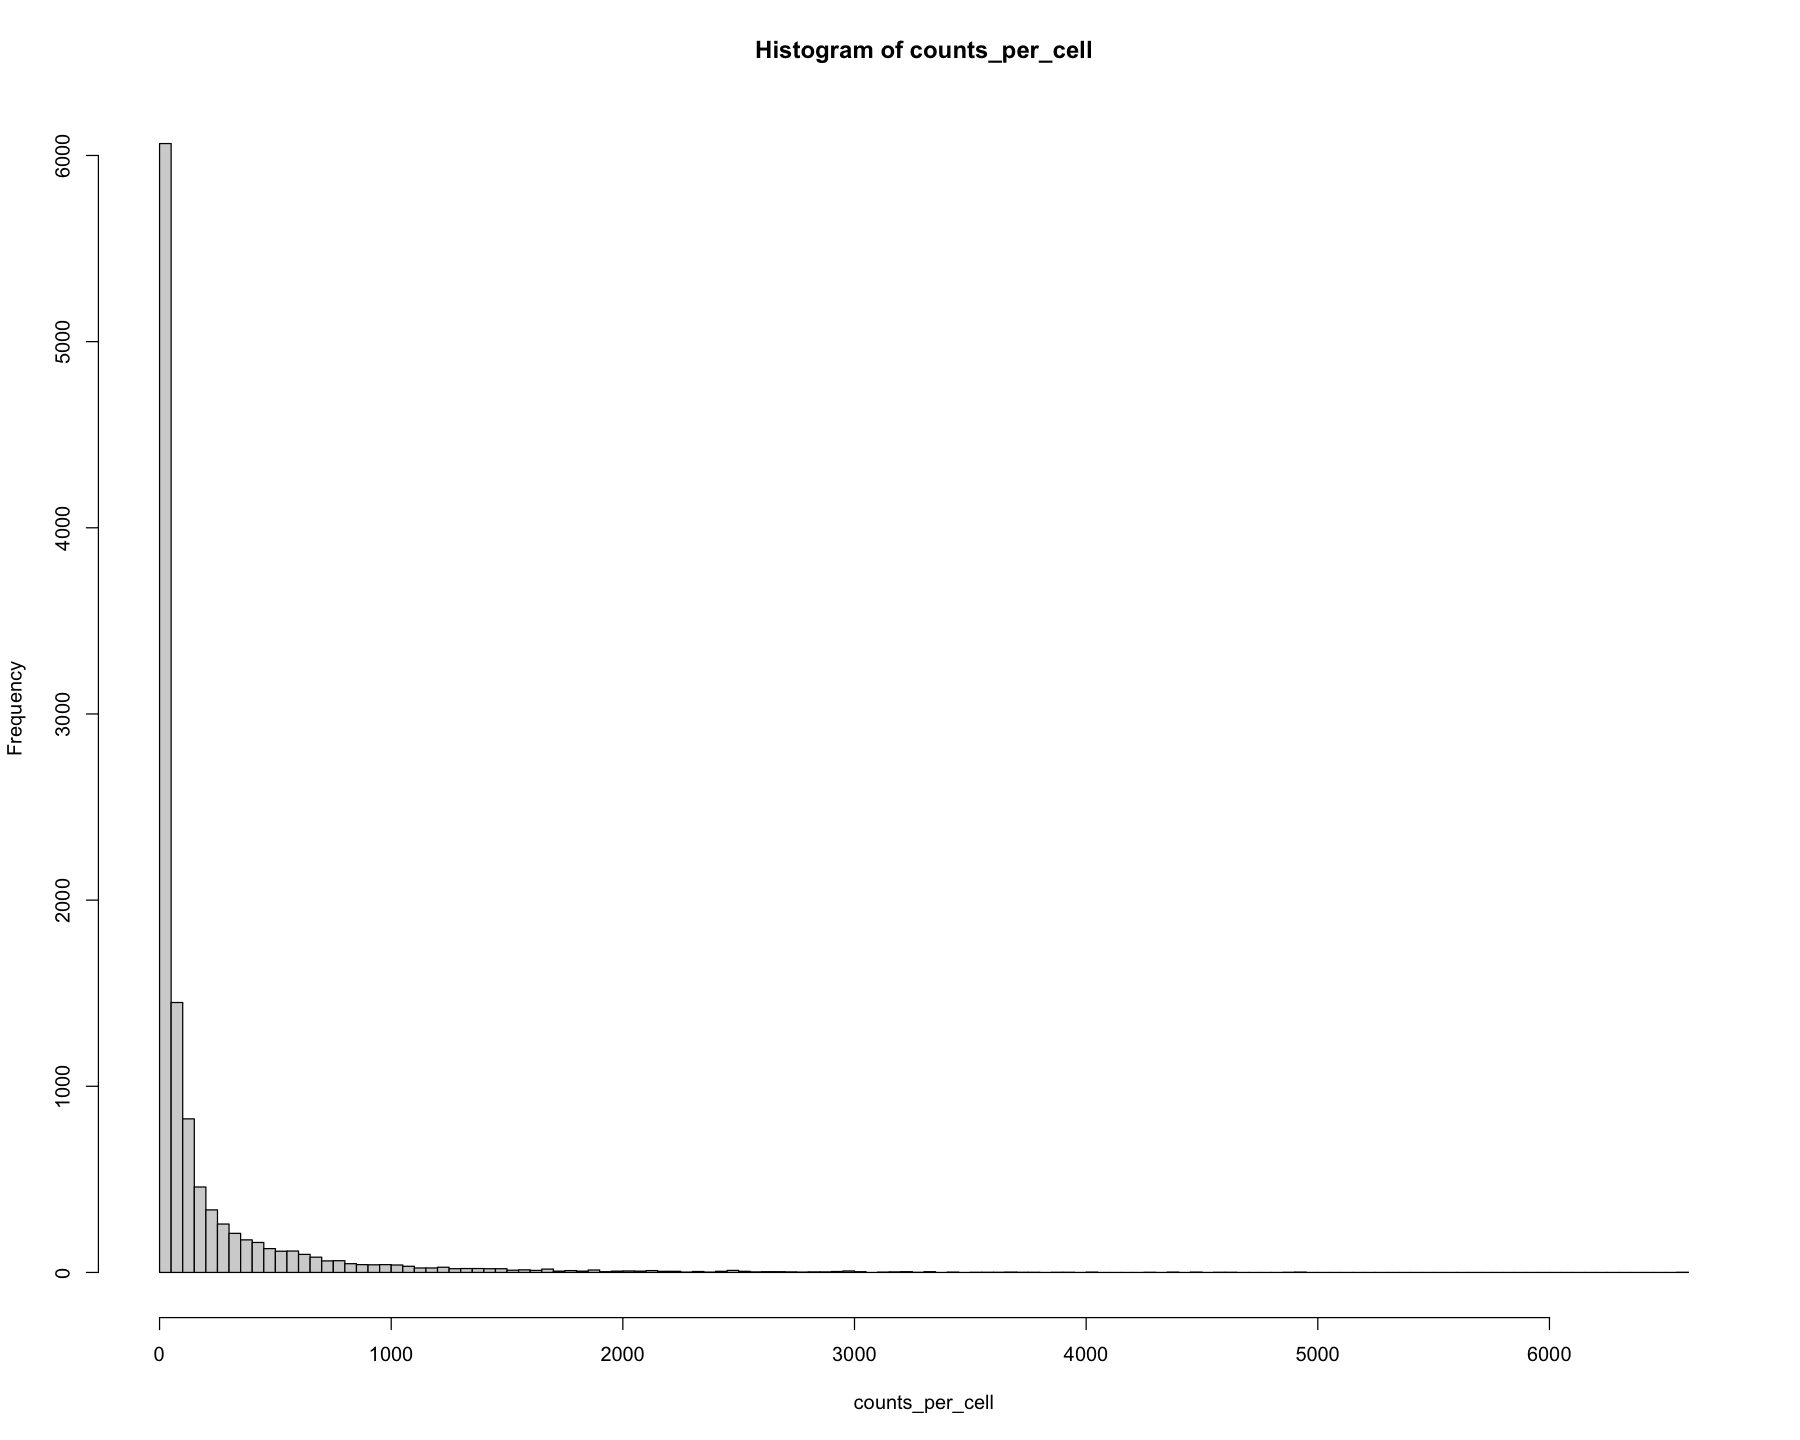

In [192]:
counts_per_cell <- colSums(hvg_mtx)
hist(counts_per_cell, breaks = 100)

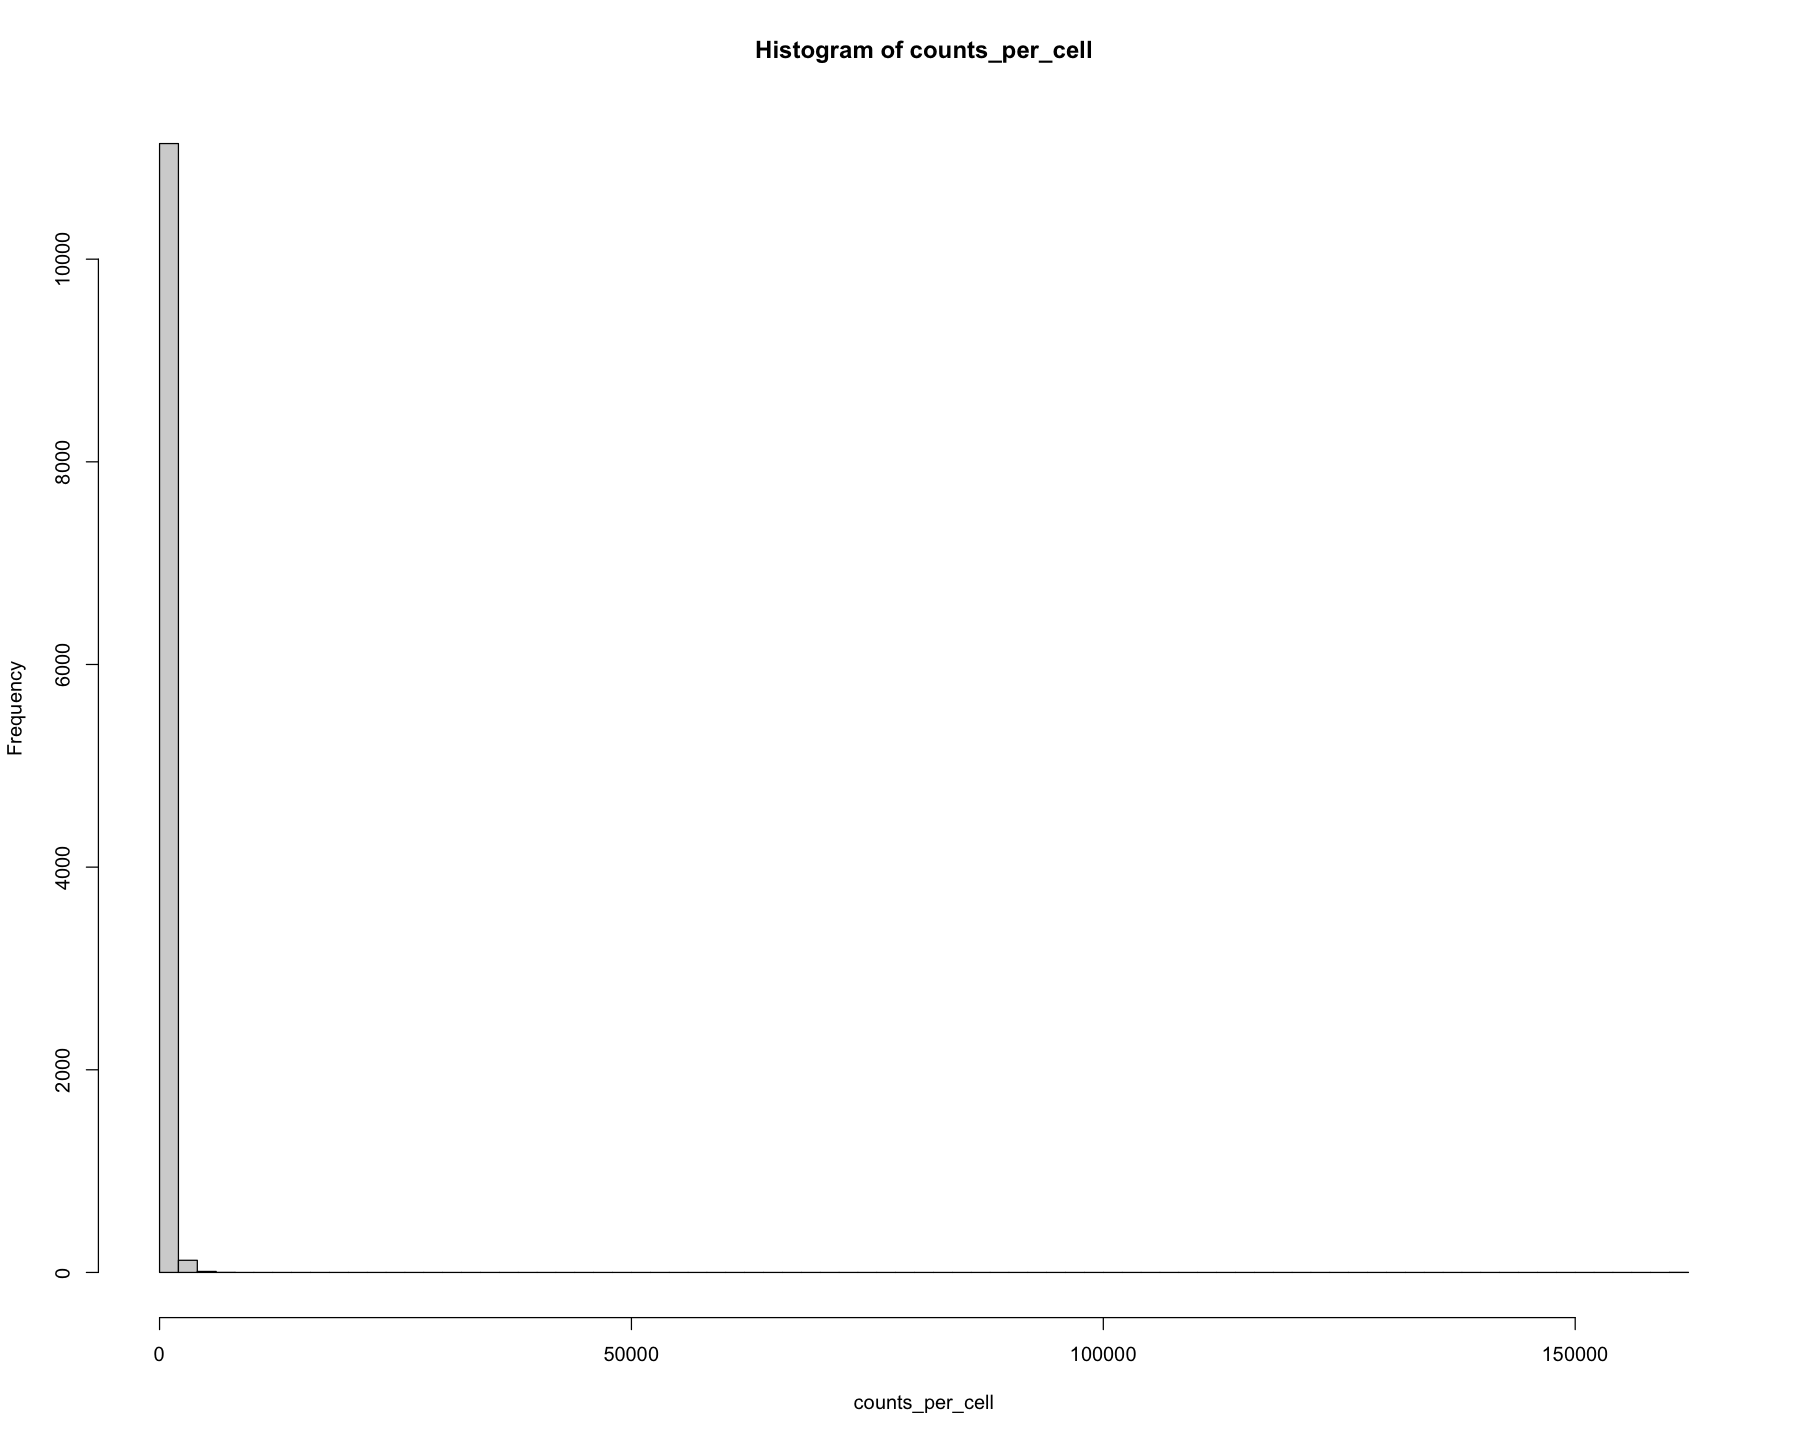

In [193]:
counts_per_cell <- colSums(sim_dat_5pct)
hist(counts_per_cell, breaks = 100)

The mean is similar to the results obtained in the parallelized code, but the median did not change in this case and the maximum increased a lot. There are also more cells with zero expression.

In [142]:
## set number of cores
bpparam <- MulticoreParam(workers = 4)

## define params
param_list <- list(
  list(mtx = mtx, meta = meta, 
    pct_out = .05, min_dist = 1, max_dist = 2),
  list(mtx = mtx, meta = meta, 
    pct_out = .1, min_dist = 1, max_dist = 2),
  list(mtx = mtx, meta = meta, 
    pct_out = .2, min_dist = 1, max_dist = 2),
  list(mtx = mtx, meta = meta, 
    pct_out = .5, min_dist = 1, max_dist = 2)
)

# run function
sims <- bplapply(param_list, function(params) {
  do.call(simulate_mtx, as.list(params))
}, BPPARAM = bpparam)

names(sims) <- c('5pct', '10pct', '20pct', '50pct')

## save matrix
saveRDS(sims, "../sim_data/prox_assign/sim_pcts.RDS")

In [ ]:
## set number of cores
bpparam <- MulticoreParam(workers = 4)

## define params
param_list <- list(
  list(mtx = mtx, meta = meta, 
    pct_out = .2, min_dist = 1, max_dist = 1.1),
  list(mtx = mtx, meta = meta, 
    pct_out = .2, min_dist = 1, max_dist = 1.5),
  list(mtx = mtx, meta = meta, 
    pct_out = .2, min_dist = 1, max_dist = 2),
  list(mtx = mtx, meta = meta, 
    pct_out = .2, min_dist = 1, max_dist = 5)
)

# run function
sims <- bplapply(param_list, function(params) {
  do.call(simulate_mtx, as.list(params))
}, BPPARAM = bpparam)

names(sims) <- c('1p1maxdiff', '1p5maxdiff', '2maxdiff', '5maxdiff')

## save matrix
saveRDS(sims, "../sim_data/prox_assign/sim_maxdiff.RDS")